In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

In [2]:
file_paths={
    'Sat':'TestbedSatJun12Flows.csv',
    'Sun':'TestbedSunJun13Flows.csv',
    'Mon':'TestbedMonJun14Flows.csv',
    'Tue':'TestbedTueJun15Flows.csv',
    'Wed':'TestbedWedJun16Flows.csv',
    'Thu':'TestbedThuJun17Flows.csv'
}

In [3]:
frames=[]
for day,path in file_paths.items():
    data2012=pd.read_csv(path)
    data2012['day']=day
    frames.append(data2012)

all_data2012=pd.concat(frames,ignore_index=True)
pd.set_option('display.max_columns',None)

In [4]:
session_2012=['totalSourceBytes','totalDestinationBytes','totalSourcePackets',
    'totalDestinationPackets','direction','sourceTCPFlagsDescription',
    'destinationTCPFlagsDescription','protocolName','sourcePort','destinationPort',
    'startDateTime','stopDateTime']
all_data2012=all_data2012[session_2012+['Label']]
all_data2012=all_data2012.copy()

In [5]:
all_data_clean = all_data2012.dropna()
all_data_clean=all_data_clean.copy()
print('Shape after dropna:', all_data_clean.shape)

Shape after dropna: (1574895, 13)


In [6]:
#flow duration
all_data_clean['startDateTime'] = pd.to_datetime(all_data_clean['startDateTime'], errors='coerce')
all_data_clean['stopDateTime'] = pd.to_datetime(all_data_clean['stopDateTime'], errors='coerce')
all_data_clean['duration'] = (all_data_clean['stopDateTime'] - all_data_clean['startDateTime']).dt.total_seconds().fillna(0).clip(lower=0)
all_data_clean.drop(['startDateTime', 'stopDateTime'], axis=1, inplace=True)

#packet ratio
all_data_clean['packet_ratio'] = (all_data_clean['totalSourcePackets'] / all_data_clean['totalDestinationPackets'].replace(0, np.nan)).fillna(0).clip(upper=10)

#byte ratio
all_data_clean['byte_ratio'] = (all_data_clean['totalSourceBytes'] / all_data_clean['totalDestinationBytes'].replace(0, np.nan)).fillna(0).clip(upper=10)

#average packet size source
all_data_clean['avg_packet_size_src'] = (all_data_clean['totalSourceBytes'] / all_data_clean['totalSourcePackets'].replace(0, np.nan)).fillna(0).clip(upper=1500)

#average packet size destination
all_data_clean['avg_packet_size_dst'] = (all_data_clean['totalDestinationBytes'] / all_data_clean['totalDestinationPackets'].replace(0, np.nan)).fillna(0).clip(upper=1500)


In [7]:
cat_cols_2012=['direction','sourceTCPFlagsDescription','destinationTCPFlagsDescription','protocolName']
all_data2012 = all_data_clean.dropna(subset=['Label'])

In [8]:
label_encoders = {}

for col in cat_cols_2012:
    le = LabelEncoder()
    all_data2012[col] = le.fit_transform(all_data2012[col])
    label_encoders[col] = le  

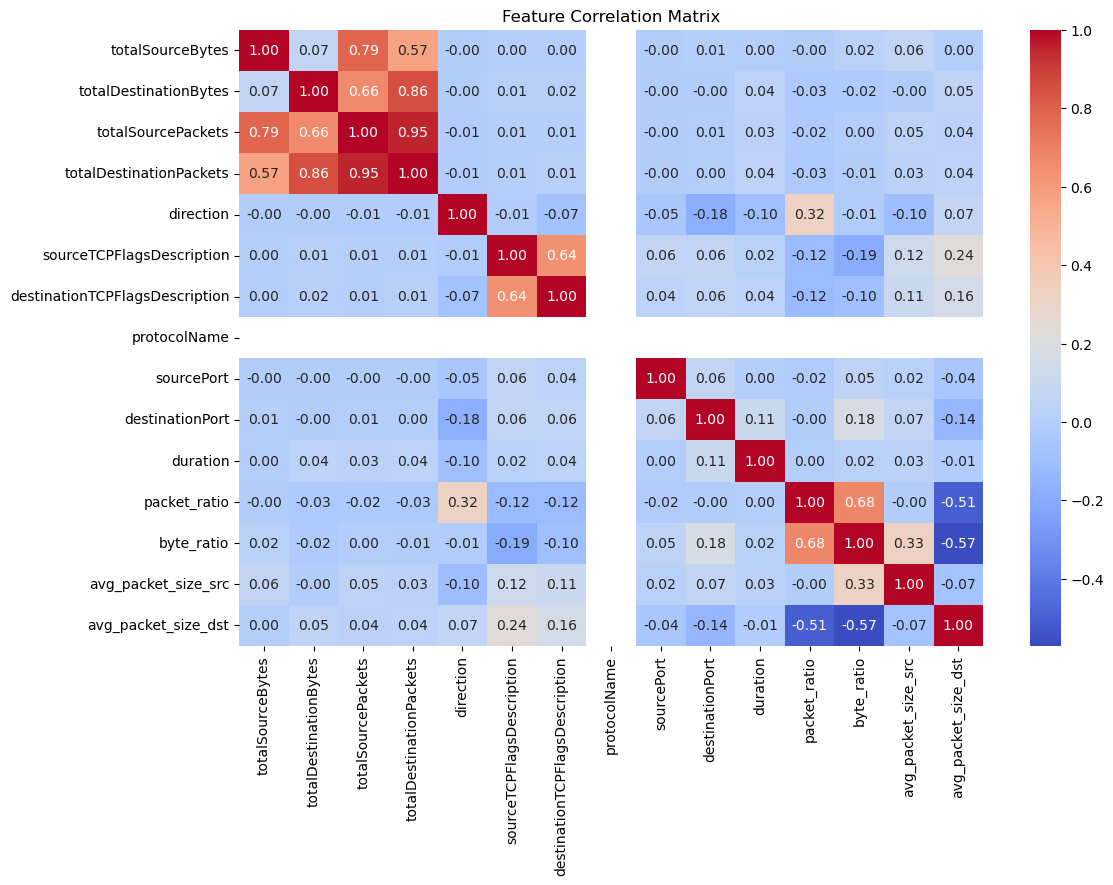

Shape before manual drop: (1574895, 16)


In [9]:
numeric_cols = all_data2012.select_dtypes(include=np.number).columns
corr_matrix = all_data2012[numeric_cols].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()
print("Shape before manual drop:", all_data2012.shape)

In [10]:
all_data2012['protocolName'].nunique(), all_data2012['protocolName'].unique()


(1, array([0]))

In [11]:
corr_drop = [
    'totalDestinationPackets','totalSourceBytes']
all_data2012_reduced = all_data2012.drop(columns=corr_drop)

print("Shape after manual drop:", all_data2012_reduced.shape)

Shape after manual drop: (1574895, 14)


In [12]:
attack_data = all_data2012_reduced[all_data2012_reduced['Label'] == 'Attack']
normal_data = all_data2012_reduced[all_data2012_reduced['Label'] != 'Attack']
attack_data_dup = pd.concat([attack_data]*10, ignore_index=True)
balanced_data = pd.concat([normal_data, attack_data_dup], ignore_index=True).sample(frac=1, random_state=42)
print('Balanced data shape:', balanced_data.shape)

Balanced data shape: (2173926, 14)


In [13]:
print(balanced_data['Label'].value_counts())
print("\nClass Ratio:")
print(balanced_data['Label'].value_counts(normalize=True))

Label
Normal    1508336
Attack     665590
Name: count, dtype: int64

Class Ratio:
Label
Normal    0.69383
Attack    0.30617
Name: proportion, dtype: float64


In [14]:
X = balanced_data.drop(columns=['Label'])
y = balanced_data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,stratify=y,random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test distribution:\n", y_test.value_counts(normalize=True))

X_train shape: (1739140, 13)
X_test shape: (434786, 13)
y_train distribution:
 Label
Normal    0.69383
Attack    0.30617
Name: proportion, dtype: float64
y_test distribution:
 Label
Normal    0.693831
Attack    0.306169
Name: proportion, dtype: float64


In [15]:
def bootstrap_train_evaluate(X_train, y_train, X_test, y_test, n_iterations=5, sample_size=0.8):
    reports = []
    for i in range(n_iterations):
        print(f"\nBootstrap Iteration {i+1}/{n_iterations}")

        # Sample with replacement
        indices = np.random.choice(len(X_train), int(len(X_train) * sample_size), replace=True)
        X_sample = X_train.iloc[indices]
        y_sample = y_train.iloc[indices]

        # Train model
        clf = RandomForestClassifier(n_estimators=100, max_depth=15, class_weight='balanced', random_state=42)
        clf.fit(X_sample, y_sample)

        # Predict on test set
        y_pred = clf.predict(X_test)

        # Evaluate
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        reports.append(report)

        # Show matrix per run
        print(confusion_matrix(y_test, y_pred))

    return reports

In [16]:
results = bootstrap_train_evaluate(X_train, y_train, X_test, y_test, n_iterations=5)


Bootstrap Iteration 1/5
[[132973    145]
 [   411 301257]]

Bootstrap Iteration 2/5
[[132964    154]
 [   471 301197]]

Bootstrap Iteration 3/5
[[132946    172]
 [   426 301242]]

Bootstrap Iteration 4/5
[[132946    172]
 [   420 301248]]

Bootstrap Iteration 5/5
[[132956    162]
 [   415 301253]]


In [17]:
def summarize_bootstrap_results(reports, label='Attack'):
    precision = np.mean([r[label]['precision'] for r in reports])
    recall = np.mean([r[label]['recall'] for r in reports])
    f1 = np.mean([r[label]['f1-score'] for r in reports])
    
    print(f"\nAverage Metrics for '{label}' class over {len(reports)} runs:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

summarize_bootstrap_results(results, label='Attack')
summarize_bootstrap_results(results, label='Normal')



Average Metrics for 'Attack' class over 5 runs:
Precision: 0.9968
Recall:    0.9988
F1-Score:  0.9978

Average Metrics for 'Normal' class over 5 runs:
Precision: 0.9995
Recall:    0.9986
F1-Score:  0.9990
